In [362]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna

In [363]:
class Dataset:
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        current_samples = self.data[idx,:]
        current_target = self.targets[idx]
        return {
            "x": torch.tensor(current_samples, dtype = torch.float),
            "y": torch.tensor(current_target, dtype = torch.long),
        }

In [364]:
class Enginee:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        
    def loss_fn(self, targets, outputs):
        return nn.CrossEntropyLoss()(outputs,targets)
    
    def training(self, data_loader):
        self.model.train()
        correct = 0
        num_samples = 0
        training_loss = 0
        
        for data in data_loader:
            x_train = data["x"]
            y_train = data["y"]
            num_samples = num_samples + len(y_train)
            self.optimizer.zero_grad()
            output = self.model(x_train)
            correct += torch.sum(y_train==torch.max(output,1)[1])
            loss = self.loss_fn(y_train,output)
            training_loss = training_loss + loss.item()
            loss.backward()
            self.optimizer.step()
            
        return training_loss/num_samples , correct/num_samples
    
    def evaluate(self, data_loader):
        self.model.eval()
        correct = 0
        num_samples = 0
        val_loss = 0
        list_with_outputs = []
        
        for data in data_loader:
            x_val = data["x"]
            y_val = data["y"]
            num_samples = num_samples + len(y_val)
            output = self.model(x_val)
            correct += torch.sum(y_val==torch.max(output,1)[1])
            loss = self.loss_fn(y_val,output)
            val_loss = val_loss + loss.item()
            list_with_outputs.append(torch.max(output, 1)[1])
            
        return val_loss/num_samples , correct/num_samples, list_with_outputs

In [365]:
class model(nn.Module):
    def __init__(self, n_features, n_targets, n_layers, hidden_size, dropout):
        super().__init__()
        
        layers = []
        for _ in range(n_layers):
            if(len(layers)==0):
                layers.append(nn.Linear(n_features,hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Linear(hidden_size,hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, n_targets))
        self.model = nn.Sequential(*layers)
        
        
    def forward(self, x):
        return self.model(x)

In [366]:
df_train = pd.read_csv(r'C:\Users\anget\OneDrive\Desktop\Arrow R&D ML Engineer - NN Ensemble Data\train.csv')
df_test = pd.read_csv(r'C:\Users\anget\OneDrive\Desktop\Arrow R&D ML Engineer - NN Ensemble Data\test.csv')

x_train = df_train.iloc[:,0:393]
x_train = x_train.values
y_train = df_train.iloc[:,393]
y_train = y_train.values
x_test = df_test.iloc[:,0:393]
x_test = x_test.values
y_test = df_test.iloc[:,393]
y_test = y_test.values
scaler = StandardScaler()

x_train , x_val , y_train, y_val = train_test_split(x_train,y_train, test_size = 0.16)

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [367]:
params = {
        "num_layers": 4,
        "hidden_size": 400,
        "dropout": 0.3,
        "learning_rate": 1e-3,
    }

## Run the model one and plot the training and validation accuracy for the model 1

In [368]:
params = {
        "num_layers": 4,
        "hidden_size": 400,
        "dropout": 0.3,
        "learning_rate": 1e-3,
    }


trainset = Dataset(x_train, y_train)
auxilary_set = Dataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(trainset , batch_size = 128, shuffle=False, drop_last = False)
auxilary_loader = torch.utils.data.DataLoader(auxilary_set , batch_size = 128, shuffle=False, drop_last = False)


    
modelo1 = model(n_features = 393 , n_targets= 10, n_layers = params['num_layers'], hidden_size=params['hidden_size'], dropout = params['dropout'])
optimizer1 = torch.optim.Adam(modelo1.parameters(), lr= params['learning_rate'])

eng1 = Enginee(modelo1, optimizer1)

best_loss = np.inf
best_acc = np.inf
early_stopping = 10
early_stopping_counter = 0
epochs = 30
list_with_training_acc = []
list_with_validation_acc = []

for i in range(0,epochs):
    train_loss, train_acc = eng1.training(train_loader)
    aux_loss, aux_acc, list_1= eng1.evaluate(auxilary_loader)
    list_with_training_acc.append(train_acc.item())
    list_with_validation_acc.append(aux_acc.item())
    print(f'{train_loss},{train_acc},{aux_loss},{aux_acc}')
    if(best_loss> aux_loss):
        best_loss = aux_loss
        best_acc = aux_acc
    else:
        early_stopping_counter += 1
        
    if(early_stopping_counter == early_stopping):
        break
        


0.00869470631319379,0.6234126687049866,0.004924193589637677,0.800000011920929
0.005337018240538854,0.7779762148857117,0.003917467563102643,0.8412500023841858
0.0044154200903953065,0.8185317516326904,0.0034627927591403328,0.8554166555404663
0.0038352441953288185,0.8403968214988708,0.003163910508155823,0.8677083253860474
0.0034808611053796044,0.8575396537780762,0.002947294811407725,0.8754166960716248
0.0032310366583248925,0.866190493106842,0.002875331916535894,0.8810416460037231
0.002967337245151164,0.8775396943092346,0.0026345509228607017,0.8954166769981384
0.002774128844104116,0.8857142925262451,0.0025316199691345293,0.8987500071525574
0.0025867995542902793,0.8922222256660461,0.002451075647647182,0.9010416865348816
0.0024519949087074824,0.8957539796829224,0.0023522670070330303,0.9049999713897705
0.0023366332539017237,0.902222216129303,0.0023845740345617137,0.9035416841506958
0.002230183765410431,0.9064285755157471,0.0022229486905659237,0.9100000262260437
0.0020917072389570494,0.9130952

Text(0.5, 1.0, 'Model 1')

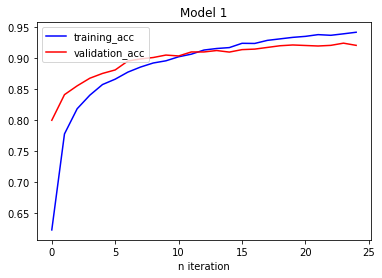

In [369]:
plt.plot(list_with_training_acc, '-b', label='training_acc')
plt.plot(list_with_validation_acc, '-r', label='validation_acc')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model 1')

In [370]:
outputs_of_model_1 = []
for i in range(0,len(list_1)):
    outputs_of_model_1.extend(list_1[i])

4459

# Run the model 2, print the training and validation accuracies, as well

In [371]:
params = {
        "num_layers": 5,
        "hidden_size": 300,
        "dropout": 0.2,
        "learning_rate": 1e-4,
    }


trainset = Dataset(x_train, y_train)
auxilary_set = Dataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(trainset , batch_size = 128, shuffle=False, drop_last = False)
auxilary_loader = torch.utils.data.DataLoader(auxilary_set , batch_size = 128, shuffle=False, drop_last = False)


    
modelo2 = model(n_features = 393 , n_targets= 10, n_layers = params['num_layers'], hidden_size=params['hidden_size'], dropout = params['dropout'])
optimizer2 = torch.optim.Adam(modelo2.parameters(), lr= params['learning_rate'])

eng2 = Enginee(modelo2, optimizer2)

best_loss = np.inf
best_acc = np.inf
early_stopping = 10
early_stopping_counter = 0
epochs = 30
list_with_training_acc = []
list_with_validation_acc = []

for i in range(0,epochs):
    train_loss, train_acc = eng2.training(train_loader)
    aux_loss, aux_acc, list_2 = eng2.evaluate(auxilary_loader)
    list_with_training_acc.append(train_acc.item())
    list_with_validation_acc.append(aux_acc.item())
    print(f'{train_loss},{train_acc},{aux_loss},{aux_acc}')
    if(best_loss> aux_loss):
        best_loss = aux_loss
        best_acc = aux_acc
    else:
        early_stopping_counter += 1
        
    if(early_stopping_counter == early_stopping):
        break

0.014413853505301097,0.35210317373275757,0.010673742617170016,0.5412499904632568
0.010057778694326915,0.5603174567222595,0.00800717314084371,0.6743749976158142
0.008169529728946232,0.6574206352233887,0.006106932672361533,0.7618749737739563
0.0067499335890724545,0.7207539677619934,0.004956964931140343,0.8035416603088379
0.005832763889006206,0.7602381110191345,0.00434337854385376,0.8291666507720947
0.005244738182851247,0.7876587510108948,0.00394358176117142,0.8458333611488342
0.0047819408443239,0.8032539486885071,0.003746282942593098,0.8458333611488342
0.004476496267413336,0.8149206638336182,0.003510355728988846,0.8587499856948853
0.004197439345575514,0.8256745934486389,0.0033303112629801037,0.8647916913032532
0.003932191781581394,0.8375793695449829,0.0031960512045770884,0.8706250190734863
0.003831109471973919,0.8422222137451172,0.0031523484829813243,0.8722916841506958
0.003655712978234367,0.8506746292114258,0.0030412543844431637,0.8772916793823242
0.003512113575660993,0.8552777767181396

Text(0.5, 1.0, 'Model 2')

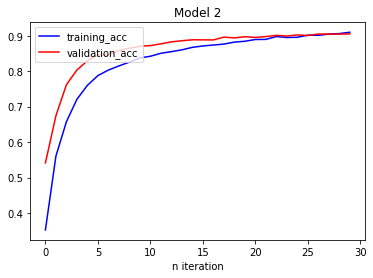

In [372]:
plt.plot(list_with_training_acc, '-b', label='training_acc')
plt.plot(list_with_validation_acc, '-r', label='validation_acc')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model 2')

In [373]:
outputs_of_model_2 = []
for i in range(0,len(list_2)):
    outputs_of_model_2.extend(list_2[i])

# Run the model 3, print the training and validation accuracies, as well

In [374]:
params = {
        "num_layers": 5,
        "hidden_size": 700,
        "dropout": 0.3,
        "learning_rate": 1e-4,
    }


trainset = Dataset(x_train, y_train)
auxilary_set = Dataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(trainset , batch_size = 128, shuffle=False, drop_last = False)
auxilary_loader = torch.utils.data.DataLoader(auxilary_set , batch_size = 128, shuffle=False, drop_last = False)


    
modelo3 = model(n_features = 393 , n_targets= 10, n_layers = params['num_layers'], hidden_size=params['hidden_size'], dropout = params['dropout'])
optimizer3 = torch.optim.Adam(modelo3.parameters(), lr= params['learning_rate'])

eng3 = Enginee(modelo3, optimizer3)

best_loss = np.inf
best_acc = np.inf
early_stopping = 10
early_stopping_counter = 0
epochs = 30
list_with_training_acc = []
list_with_validation_acc = []

for i in range(0,epochs):
    train_loss, train_acc = eng3.training(train_loader)
    aux_loss, aux_acc, list_3 = eng3.evaluate(auxilary_loader)
    list_with_training_acc.append(train_acc.item())
    list_with_validation_acc.append(aux_acc.item())
    print(f'{train_loss},{train_acc},{aux_loss},{aux_acc}')
    if(best_loss> aux_loss):
        best_loss = aux_loss
        best_acc = aux_acc
    else:
        early_stopping_counter += 1
        
    if(early_stopping_counter == early_stopping):
        break

0.013213082381657191,0.4029761850833893,0.009099523338178794,0.6043750047683716
0.008689712818179813,0.6187301874160767,0.006125955941776434,0.7514583468437195
0.006577123926272468,0.7215873003005981,0.004750197995454073,0.8060416579246521
0.005415625804000431,0.7731349468231201,0.00407294653976957,0.8345833420753479
0.0047509519945061396,0.8029364943504333,0.0037049606877068678,0.8477083444595337
0.004259986859701929,0.823452353477478,0.0034616913460195063,0.8585416674613953
0.003945348453190591,0.8378968238830566,0.003203839600707094,0.8677083253860474
0.0036311628787763536,0.8471428751945496,0.0029854999637852113,0.8777083158493042
0.0034528390247197376,0.8558729887008667,0.002908244359617432,0.8833333253860474
0.003213548558571982,0.8662301301956177,0.0028302035325517257,0.887499988079071
0.0030317136881843447,0.8730555772781372,0.0026838363024095694,0.893541693687439
0.0029042530881743583,0.8789682388305664,0.0027138268233587344,0.8931249976158142
0.0027726731892852557,0.885158717

Text(0.5, 1.0, 'Model 3')

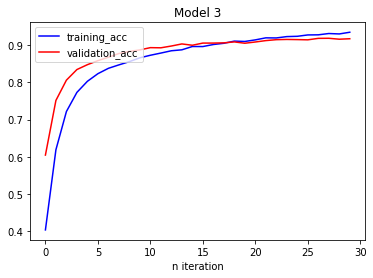

In [375]:
plt.plot(list_with_training_acc, '-b', label='training_acc')
plt.plot(list_with_validation_acc, '-r', label='validation_acc')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model 3')

In [376]:
outputs_of_model_3 = []
for i in range(0,len(list_3)):
    outputs_of_model_3.extend(list_3[i])

# Run the model 4, print the training and validation accuracies, as well

In [377]:
params = {
        "num_layers": 5,
        "hidden_size": 700,
        "dropout": 0.3,
        "learning_rate": 1e-3,
    }


trainset = Dataset(x_train, y_train)
auxilary_set = Dataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(trainset , batch_size = 128, shuffle=False, drop_last = False)
auxilary_loader = torch.utils.data.DataLoader(auxilary_set , batch_size = 128, shuffle=False, drop_last = False)


    
modelo4 = model(n_features = 393 , n_targets= 10, n_layers = params['num_layers'], hidden_size=params['hidden_size'], dropout = params['dropout'])
optimizer4 = torch.optim.Adam(modelo4.parameters(), lr= params['learning_rate'])

eng4 = Enginee(modelo4, optimizer4)

best_loss = np.inf
best_acc = np.inf
early_stopping = 10
early_stopping_counter = 0
epochs = 30
list_with_training_acc = []
list_with_validation_acc = []

for i in range(0,epochs):
    train_loss, train_acc = eng4.training(train_loader)
    aux_loss, aux_acc, list_4 = eng4.evaluate(auxilary_loader)
    list_with_training_acc.append(train_acc.item())
    list_with_validation_acc.append(aux_acc.item())
    print(f'{train_loss},{train_acc},{aux_loss},{aux_acc}')
    if(best_loss> aux_loss):
        best_loss = aux_loss
        best_acc = aux_acc
    else:
        early_stopping_counter += 1
        
    if(early_stopping_counter == early_stopping):
        break

0.007994854185316298,0.6532142758369446,0.004590762661149104,0.8147916793823242
0.004724767178533569,0.8064682483673096,0.0035295433923602103,0.8514583110809326
0.003884704755175681,0.8400793671607971,0.0031183499346176782,0.8725000023841858
0.0033247702060237765,0.8642063736915588,0.0029167682894816003,0.8808333277702332
0.0029492291009851866,0.879365086555481,0.0027887881205727657,0.8839583396911621
0.0026723373279212014,0.8861904740333557,0.0025574355324109394,0.8952083587646484
0.0024053900653407687,0.9017460346221924,0.0025274696480482818,0.9010416865348816
0.00226584083504147,0.9053968191146851,0.0023560919985175133,0.9066666960716248
0.002112520185136606,0.9135714173316956,0.002228099753459295,0.9100000262260437
0.0019778754026998605,0.9172618985176086,0.0022714096990724404,0.9139583110809326
0.0018755838904707205,0.9207539558410645,0.0022083630443861086,0.9127083420753479
0.0017660494648393185,0.9258730411529541,0.0023032992333173754,0.9085416793823242
0.0016139058703704486,0.9

Text(0.5, 1.0, 'Model 4')

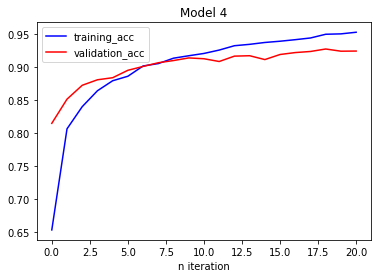

In [378]:
plt.plot(list_with_training_acc, '-b', label='training_acc')
plt.plot(list_with_validation_acc, '-r', label='validation_acc')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model 4')

In [379]:
outputs_of_model_4 = []
for i in range(0,len(list_4)):
    outputs_of_model_4.extend(list_4[i])

# Run the model 5, print the training and validation accuracies, as well

In [380]:
params = {
        "num_layers": 6,
        "hidden_size": 1000,
        "dropout": 0.2,
        "learning_rate": 1e-3,
    }


trainset = Dataset(x_train, y_train)
auxilary_set = Dataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(trainset , batch_size = 128, shuffle=False, drop_last = False)
auxilary_loader = torch.utils.data.DataLoader(auxilary_set , batch_size = 128, shuffle=False, drop_last = False)


    
modelo5 = model(n_features = 393 , n_targets= 10, n_layers = params['num_layers'], hidden_size=params['hidden_size'], dropout = params['dropout'])
optimizer5 = torch.optim.Adam(modelo5.parameters(), lr= params['learning_rate'])

eng5 = Enginee(modelo5, optimizer5)

best_loss = np.inf
best_acc = np.inf
early_stopping = 10
early_stopping_counter = 0
epochs = 30
list_with_training_acc = []
list_with_validation_acc = []

for i in range(0,epochs):
    train_loss, train_acc = eng5.training(train_loader)
    aux_loss, aux_acc, list_5 = eng5.evaluate(auxilary_loader)
    list_with_training_acc.append(train_acc.item())
    list_with_validation_acc.append(aux_acc.item())
    print(f'{train_loss},{train_acc},{aux_loss},{aux_acc}')
    if(best_loss> aux_loss):
        best_loss = aux_loss
        best_acc = aux_acc
    else:
        early_stopping_counter += 1
        
    if(early_stopping_counter == early_stopping):
        break

0.006677349445129197,0.7128174901008606,0.004398354074607293,0.8206250071525574
0.0038761631304782534,0.8415079116821289,0.003608129673327009,0.8583333492279053
0.0030295572305719057,0.8749603033065796,0.0032180416149397693,0.8729166388511658
0.002530573689866634,0.8951190710067749,0.0029503419250249863,0.8870833516120911
0.0022372906146541473,0.9080555438995361,0.002753684393440684,0.8933333158493042
0.0019413590549476564,0.9186508059501648,0.002872125506401062,0.8970833420753479
0.0017657001233763166,0.928174614906311,0.002740694411719839,0.8993750214576721
0.0015338587731359497,0.9360714554786682,0.0028601947240531446,0.8983333110809326
0.0014127312510436962,0.9416269659996033,0.0028022528160363434,0.8968750238418579
0.0013075935340944736,0.943928599357605,0.002575731392328938,0.902916669845581
0.001230422393197105,0.946825385093689,0.0026703581213951113,0.9068750143051147
0.001074414848394337,0.9530555605888367,0.0024912169482558966,0.9150000214576721
0.0010498858331185249,0.954880

Text(0.5, 1.0, 'Model 5')

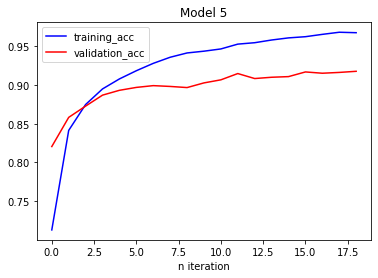

In [381]:
plt.plot(list_with_training_acc, '-b', label='training_acc')
plt.plot(list_with_validation_acc, '-r', label='validation_acc')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model 5')

In [382]:
outputs_of_model_5 = []
for i in range(0,len(list_5)):
    outputs_of_model_5.extend(list_5[i])

# The outputs_of_models list contains the probabilities of every model, useful for calculating the validation accuracy of the ensemble model

In [400]:
y_prediction_ensemble_val = []
for i in range(0,len(y_val)):
    lista = [outputs_of_model_1[i],outputs_of_model_2[i],outputs_of_model_3[i],outputs_of_model_4[i],outputs_of_model_5[i]]
    counts = np.bincount(lista)
    y_prediction_ensemble_val.append(np.argmax(counts))

In [401]:
counter = 0
for i in range(0,len(y_val)):
    if(y_val[i]==y_prediction_ensemble_val[i]):
        counter += 1
        
print('Validation accuracy for the ensemble method:', counter/len(y_val))

Validation accuracy for the ensemble method: 0.9295833333333333


In [404]:
# for decision on the ensembling method, i use the majority voting

In [406]:
test_set = Dataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set , batch_size = 128, shuffle=False, drop_last = False)

aux_loss, aux_acc, list_1_for_test = eng1.evaluate(test_loader)
aux_loss, aux_acc, list_2_for_test = eng2.evaluate(test_loader)
aux_loss, aux_acc, list_3_for_test = eng3.evaluate(test_loader)
aux_loss, aux_acc, list_4_for_test = eng4.evaluate(test_loader)
aux_loss, aux_acc, list_5_for_test = eng5.evaluate(test_loader)

test_outputs_of_model_1 = []
for i in range(0,len(list_1_for_test)):
    test_outputs_of_model_1.extend(list_1_for_test[i])
    
test_outputs_of_model_2 = []
for i in range(0,len(list_2_for_test)):
    test_outputs_of_model_2.extend(list_2_for_test[i])
    
test_outputs_of_model_3 = []
for i in range(0,len(list_3_for_test)):
    test_outputs_of_model_3.extend(list_3_for_test[i])
    
test_outputs_of_model_4 = []
for i in range(0,len(list_4_for_test)):
    test_outputs_of_model_4.extend(list_4_for_test[i])
    
test_outputs_of_model_5 = []
for i in range(0,len(list_5_for_test)):
    test_outputs_of_model_5.extend(list_5_for_test[i])
    
y_prediction_ensemble_test = []
for i in range(0,len(y_test)):
    lista = [test_outputs_of_model_1[i],test_outputs_of_model_2[i],test_outputs_of_model_3[i],test_outputs_of_model_4[i],test_outputs_of_model_5[i]]
    counts = np.bincount(lista)
    y_prediction_ensemble_test.append(np.argmax(counts))

counter = 0
for i in range(0,len(y_test)):
    if(y_test[i]==y_prediction_ensemble_test[i]):
        counter += 1
        
print('Test accuracy for the ensemble method:', counter/len(y_test))

Test accuracy for the ensemble method: 0.8215


# Thank you very much

# Angelis Tzouchas